In [6]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# Specify each path

In [7]:
dataset = '/home/trinhnc/catkin_ws/src/ros_hand_gesture_recognition/src/model/keypoint_classifier/keypoint.csv'
model_save_path = '/home/trinhnc/catkin_ws/src/ros_hand_gesture_recognition/src/model/keypoint_classifier/keypoint_classifier.hdf5'
tflite_save_path = '/home/trinhnc/catkin_ws/src/ros_hand_gesture_recognition/src/model/keypoint_classifier/keypoint_classifier.tflite'

# Set number of classes

In [18]:
NUM_CLASSES = 6

# Dataset reading

In [19]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [20]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [22]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [23]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout_2 (Dropout)         (None, 42)                0         
                                                                 
 dense_3 (Dense)             (None, 20)                860       
                                                                 
 dropout_3 (Dropout)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                210       
                                                                 
 dense_5 (Dense)             (None, 6)                 66        
                                                                 
Total params: 1,136
Trainable params: 1,136
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [25]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [26]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
28/38 [=====================>........] - ETA: 0s - loss: 1.8059 - accuracy: 0.2252
Epoch 1: saving model to /home/trinhnc/catkin_ws/src/ros_hand_gesture_recognition/src/model/keypoint_classifier/keypoint_classifier.hdf5
38/38 [==============================] - 1s 16ms/step - loss: 1.7791 - accuracy: 0.2399 - val_loss: 1.6251 - val_accuracy: 0.3581
Epoch 2/1000
32/38 [========================>.....] - ETA: 0s - loss: 1.5990 - accuracy: 0.3284
Epoch 2: saving model to /home/trinhnc/catkin_ws/src/ros_hand_gesture_recognition/src/model/keypoint_classifier/keypoint_classifier.hdf5
38/38 [==============================] - 0s 6ms/step - loss: 1.5884 - accuracy: 0.3320 - val_loss: 1.4731 - val_accuracy: 0.3830
Epoch 3/1000
26/38 [===================>..........] - ETA: 0s - loss: 1.4777 - accuracy: 0.3705
Epoch 3: saving model to /home/trinhnc/catkin_ws/src/ros_hand_gesture_recognition/src/model/keypoint_classifier/keypoint_classifier.hdf5
38/38 [==============================] - 0

In [27]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

13/13 [==============================] - 0s 2ms/step - loss: 0.1405 - accuracy: 0.9701


In [28]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [29]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 97ms/step
[6.7029712e-03 1.4374901e-01 4.5037199e-10 2.2386561e-10 8.4954673e-01
 1.3483615e-06]
4


# Confusion matrix

51/51 [==============================] - 0s 2ms/step


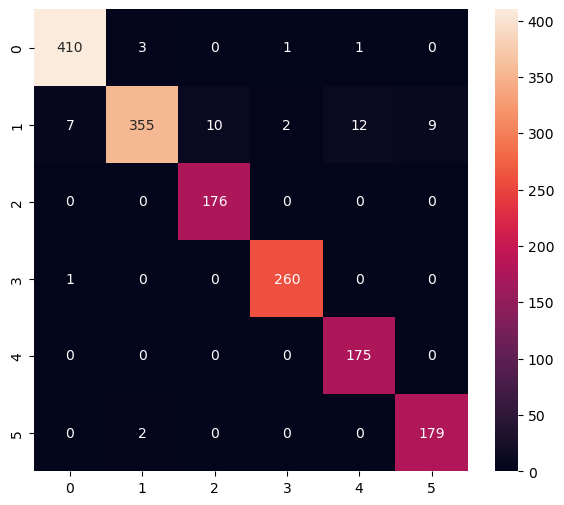

Classification Report
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       415
           1       0.99      0.90      0.94       395
           2       0.95      1.00      0.97       176
           3       0.99      1.00      0.99       261
           4       0.93      1.00      0.96       175
           5       0.95      0.99      0.97       181

    accuracy                           0.97      1603
   macro avg       0.96      0.98      0.97      1603
weighted avg       0.97      0.97      0.97      1603



In [31]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [32]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [33]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmpk8m91t3_/assets


2022-12-31 00:20:20.189384: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-31 00:20:20.189436: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-12-31 00:20:20.190119: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpk8m91t3_
2022-12-31 00:20:20.226265: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-12-31 00:20:20.226322: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmpk8m91t3_
2022-12-31 00:20:20.306180: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2022-12-31 00:20:20.313159: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2022-12-31 00:20:20.488371: I tensorflow/cc/saved_model/loader.cc:213] Running initialization op on SavedModel bundle at path: /tmp/tmpk8m91t3_
2022-12

6660

# Inference test

In [34]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [35]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [36]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [37]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 1.59 ms, sys: 128 µs, total: 1.72 ms
Wall time: 5.75 ms


In [38]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[6.7029702e-03 1.4374894e-01 4.5037366e-10 2.2386601e-10 8.4954673e-01
 1.3483626e-06]
4
